## EDA - Predicting Project Success

This notebook is an exploratory analysis of the date for the "Predicting Project Success" project.

Member of the team:
- An Hoang
- Michael Sedelmeyer
- Mark McDonald

## Notebook Index

<a name='index'></a>

### 1) Notebook Setup 
&emsp; &emsp; <a href=#imports>Imports</a>  // <a href=#helpers>Helper Functions</a> // <a href=#read>Read Dataset</a>

### 2) Analysis

#### &emsp; &emsp; a) <a href=#cleanup>Data Cleanup</a>

#### &emsp; &emsp; b) <a href=#counts>Counts</a>

#### &emsp; &emsp; c) <a href=#trends>Trends</a>

#### &emsp; &emsp; d) <a href=#budget>Budget Values</a>

#### &emsp; &emsp; e) <a href=#missing>"Missing-ness"</a>

#### &emsp; &emsp; f) <a href=#summary>Summary & Findings</a>

#### &emsp; &emsp; g) <a href=#open>Open Items / Unanswered</a>


<a name='imoprts'></a>

## Imports
Imports for function used in this notebook.

<a href=#index>index</a>

In [91]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# BOKEH IMPORTS
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format


# Improve resolution of output graphcis
%config InlineBackend.figure_format ='retina'

Loading BokehJS ...

<a name='helpers'></a>
## Helper Functions
Functions used to accomplish repeated tasks in this notebook.

<a href=#index>index</a>

### Bokeh Helper Functions

In [2]:
def count_chart(d, count_this, by_this, function='unique'):
    """
    Plot counts by column
    """
    
    if function == 'unique':
        grouping = d.groupby(by_this).nunique()
    elif function == 'count':
        grouping = d.groupby(by_this).count()
    
    grouping['left'] = range(0, len(grouping))
    grouping['right'] = grouping['left'].values + 1 

    tools = [HoverTool(
                        tooltips=[
                            (f"{by_this}", f"@{by_this}"),
                            (f"Num {count_this}'s", f"@{count_this}"),]
                      )
            ]

    p = figure(title=f"Count of Number of {count_this}'s by {by_this}", tools=tools, 
               plot_height=500, plot_width=700, background_fill_color="#fafafa",
              x_range=list(grouping.index))


    p.quad(source=ColumnDataSource(grouping[[count_this, 'left', 'right']]), 
           top=count_this, bottom=0, left='left', right='right',
           line_color="white", alpha=0.7)
    
    p.y_range.start = 0
    p.xaxis.axis_label = f'{by_this}'
    p.yaxis.axis_label = f"Num {count_this}'s"
    p.grid.grid_line_color="white"
    p.xaxis.major_label_orientation = math.pi/3
    show(p)

In [3]:
def hist_chart(d, count_this, for_each):
    
    num = d.groupby(by=for_each).nunique()[count_this]
    
    _left = [x for x in range(1, max(num))]
    _right = list(np.array(_left) + 1)
    
    hist, _ = np.histogram(num, bins=len(_left))

    tools = [HoverTool(
                        tooltips=[
                            (f"This many '{for_each}'", "@top"),
                            (f"Have this many '{count_this}'", "@left"),
                            ]
                      )
            ]
    p = figure(title=f"Count of Number of '{count_this}'", tools=tools, 
               plot_height=300, plot_width=700, background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=_left, right=_right, line_color="white", alpha=0.7) #, fill_color="navy", )
    p.y_range.start = 0
    p.xaxis.axis_label = f"Num '{count_this}'"
    p.yaxis.axis_label = f"Num '{for_each}'"
    p.grid.grid_line_color="white"
    show(p)

<a name='read'></a>
## Read Dataset
Read the dataset and perform basic manipulation of headers and some fields including formatting.

<a href=#index>index</a>

In [4]:
file_path = '../data/Capital_Projects.csv'
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [5]:
data = pd.read_csv(file_path)

In [6]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 2259
Number of unique projects in dataset: 378


<a name='cleanup'></a>
## Data Cleanup
The dataset includes a sizable number of NaN values.  The handling for each of them is different depending on the circumstances.  This section includes the steps necessary to clean the data and remove NaN values.

<a href=#index>index</a>

In [7]:
# Use 'underscores' in column headers instead of spaces
old_cols = list(data.columns)
new_cols = [s.replace(' ', '_') for s in old_cols]
rename_dict = {k:v for k,v in zip(old_cols, new_cols)}
data.rename(columns=rename_dict, inplace=True)

# Change Date fields to date-type
data['Date_Reported_As_Of'] = pd.to_datetime(data['Date_Reported_As_Of'])
data['Design_Start'] = pd.to_datetime(data['Design_Start'])
data['Forecast_Completion'] = pd.to_datetime(data['Forecast_Completion'])

In [8]:
# make sure data is sorted properly
data = data.sort_values(by=['PID', 'Date_Reported_As_Of'])

In [9]:
# rename phases to indicate thier sequence
rename_phases = {
                 'IT':'0-IT',
                 'Scoping/Planning':'1-Scoping/Planning',
                 'Design':'2-Design',
                 'Construction Procurement':'3-Construction Procurement',
                 'Construction':'4-Construction',
                 'Close-Out':'5-Close-Out'}
data.Current_Phase = data.Current_Phase.map(rename_phases)

In [10]:
# Create an original budget column
# The first line in any project is the source of the original budget.
# The original budget for the entire project can be calculated from the
# first line of any project:
# Original_Budget = Budget_Forecast - Latest_Budget_Changes

# if 'Latest_Budget_Changes' is NaN, make it 0 (this is the best info we have)
data['Latest_Budget_Changes'] = data['Latest_Budget_Changes'].fillna(0)

# loop through projects - create dict of original_budget values
orig_budgets_dict = {}
for PID in data['PID'].unique():
    df = data[data['PID']==PID].sort_values(by='Date_Reported_As_Of')
    
    original_budget = df.iloc[0]['Budget_Forecast']-df.iloc[0]['Latest_Budget_Changes']
    orig_budgets_dict.update({PID: original_budget} )


In [11]:
# Several Projects need manual updates because of poor data quality
for k,v in orig_budgets_dict.items():
    if math.isnan(v):
        print(k, v)

569 nan
595 nan
598 nan
600 nan
696 nan
697 nan
707 nan
800 nan
810 nan
870 nan
898 nan
899 nan
900 nan
901 nan
932 nan
934 nan


In [12]:
orig_budgets_dict.update({569: 28932000.00})
orig_budgets_dict.update({595: 0})
orig_budgets_dict.update({598: 0})
orig_budgets_dict.update({600: 0})
orig_budgets_dict.update({696: 0})
orig_budgets_dict.update({697: 0})
orig_budgets_dict.update({707: 0})
orig_budgets_dict.update({800: 0})
orig_budgets_dict.update({810: 0})
orig_budgets_dict.update({870: 0})
orig_budgets_dict.update({898: 27500000})
orig_budgets_dict.update({899: 27500000})
orig_budgets_dict.update({900: 27400000})
orig_budgets_dict.update({901: 27500000})
orig_budgets_dict.update({932: 0})
orig_budgets_dict.update({934: 0})

In [13]:
# apply the original budget values to each project
# create columns series and add it to the dataframe
def update_budget(s):
    return orig_budgets_dict.get(s.PID)

data.insert(10, 'Original_Budget', data.apply(update_budget, axis=1))

In [14]:
# Check that no values are NaN
data[data['Original_Budget'].isna()]

,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Original_Budget,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes


In [15]:
# Where text descriptions are missing use 'not_specified'
data['Description'] = data['Description'].fillna('not_specified')
data['Borough'] = data['Borough'].fillna('not_specified')
data['Current_Phase'] = data['Current_Phase'].fillna('not_specified')
data['Client_Agency'] = data['Client_Agency'].fillna('not_specified')

In [16]:
# several projects have final lines that have no information - remove them
drop_idxs = data[(data['Current_Phase']=='not_specified') & (data['Design_Start'].isna()) & (data['Latest_Schedule_Changes'].isna()) & (data['Budget_Forecast'].isna()) & (data['Latest_Budget_Changes']==0)].index
data = data.drop(index=drop_idxs)

In [17]:
# NaN values per column
data.isna().sum()

Date_Reported_As_Of          0
PID                          0
Project_Name                 0
Description                  0
Category                     0
Borough                      0
Managing_Agency              0
Client_Agency                0
Current_Phase                0
Design_Start                59
Original_Budget              0
Budget_Forecast              1
Latest_Budget_Changes        0
Total_Budget_Changes        53
Forecast_Completion         17
Latest_Schedule_Changes    288
Total_Schedule_Changes      61
dtype: int64

### Calculate Missing NA's where Possible

In [18]:
# Fix entries where Total_Budget_Changes is nan

# Can be calculated as the sum of all 'Latest_Budget_Changes'

# loop through projects - create dict of 'Total_Budget_Changes' values
ttl_budget_changes_dict = {}
for PID in data['PID'].unique():
    df = data[data['PID']==PID].sort_values(by='Date_Reported_As_Of')
    
    # if no nan's, just take the last ttl value
    if len(df['Total_Budget_Changes'].isna()) == 0:
        ttl_budget_changes_dict.update({PID: df.iloc[-1]['Total_Budget_Changes']})
    else: # there is at least one nan
        # if they are all nan - calc as the sum of 'Latest_Budget_Changes'
        if data[data['PID']==PID]['Total_Budget_Changes'].isna().all():
            ttl_budget_changes_dict.update({PID: df['Latest_Budget_Changes'].sum()})
        
        else: # not all are nan, take the max of 'Total_Budget_Changes'
            ttl_budget_changes_dict.update({PID: df['Total_Budget_Changes'].max()})

# apply the total budget changes values to each project
# create columns series and add it to the dataframe
def update_changes(s):
    return ttl_budget_changes_dict.get(s.PID)

data['Total_Budget_Changes'] = data.apply(update_changes, axis=1)

In [19]:
# Update/Correct Latest_Schedule_Changes that have nan values

# if the first entry has a nan, make it 0

# loop through projects - create dict of 'Total_Budget_Changes' values
latest_schedule_changes_list = []

new_PID = False
prev_row = None
for i, row in data.iterrows():
    
    # see if this is the first entry for a project
    try:
        if row.PID != prev_row.PID:
            new_PID = True
    except:
        new_PID = True
    
    x = row['Latest_Schedule_Changes']
    
    # if nan and first entry, make 0
    if pd.isna(row['Latest_Schedule_Changes']) and new_PID:
        x = 0
        
    # if nan and not first row, calculate 
    elif pd.isna(row['Latest_Schedule_Changes']) and not new_PID:
        
        # if forecast_completion is nan, we can back into the value
        if pd.isna(row['Forecast_Completion']) or pd.isna(prev_row['Forecast_Completion']):
            
            
            # if the changes are all accounted for, make the entry 0
            if row['Total_Schedule_Changes'] - data[data.PID == row.PID]['Latest_Schedule_Changes'].sum() == 0:
                x = 0
            
            # see if this is the only NA row, we can back into the value
            elif data[data.PID == row.PID]['Latest_Schedule_Changes'].isna().sum() == 1:
                x = row['Total_Schedule_Changes'] - data[data.PID == row.PID]['Latest_Schedule_Changes'].sum()
            
            # othewise, can't calculate
                
        else: # there is a forecast_completion date and we can easily calculte the change
            x = row['Forecast_Completion'] - prev_row['Forecast_Completion']

    latest_schedule_changes_list.append(x)
    
    new_PID = False
    prev_row = row.copy()

data['Latest_Schedule_Changes'] = latest_schedule_changes_list
    

In [20]:
# this project is a lost cause
data[data['Latest_Schedule_Changes'].isna()]


,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Original_Budget,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes
2084,2019-01-01,863,Network Infrastructure Refresh Program,This project has a two-fold basis: 1) The ongo...,"Health and Hospitals, IT",not_specified,HHC,H+H,0-IT,NaT,0.00,0.00,0.00,"160,090,000.00",NaT,nan,nan
2085,2019-05-01,863,Network Infrastructure Refresh Program,This project has a two-fold basis: 1) The ongo...,"Health and Hospitals, IT",not_specified,HHC,H+H,0-IT,NaT,0.00,"160,090,000.00","160,090,000.00","160,090,000.00",NaT,nan,nan
2086,2019-09-01,863,Network Infrastructure Refresh Program,This project has a two-fold basis: 1) The ongo...,"Health and Hospitals, IT",not_specified,HHC,H+H,0-IT,NaT,0.00,"160,090,000.00",0.00,"160,090,000.00",2023-12-31,nan,nan


In [21]:
# Now, calculate any missing Forecast_Completion values

fc_completion_list = []

new_PID = False
prev_row = None
for i, row in data.iterrows():
    
    # see if this is the first entry for a project
    try:
        if row.PID != prev_row.PID:
            new_PID = True
    except:
        new_PID = True
        
    x = row['Forecast_Completion']
    
    if pd.isna(x) and not new_PID:
        # we can back into the date
        x = prev_row['Forecast_Completion'] + timedelta(int(row['Latest_Schedule_Changes']))
        
    fc_completion_list.append(x)
        
    
data['Forecast_Completion'] = fc_completion_list

In [22]:
# now calculate any missing Total_Schedule_Changes

ttl_fc_changes_dict = {}
for PID in data['PID'].unique():
    df = data[data['PID']==PID].sort_values(by='Date_Reported_As_Of')
    
    # if no nan's, just take the last ttl value
    if len(df['Total_Schedule_Changes'].isna()) == 0:
        ttl_fc_changes_dict.update({PID: df.iloc[-1]['Total_Schedule_Changes']})
    else: # there is at least one nan
        # if they are all nan - calc as the sum of 'Latest_Budget_Changes'
        if data[data['PID']==PID]['Total_Schedule_Changes'].isna().all():
            ttl_fc_changes_dict.update({PID: df['Latest_Schedule_Changes'].sum()})
        
        else: # not all are nan, take the max of 'Total_Budget_Changes'
            ttl_fc_changes_dict.update({PID: df['Total_Schedule_Changes'].max()})


def update_changes(s):
    return ttl_fc_changes_dict.get(s.PID)

data['Total_Schedule_Changes'] = data.apply(update_changes, axis=1)


In [23]:
# Create an original schedule column

# in the first line of a project, back into the origonal date
# this is the best that we can do

try:
    data.drop(columns=['Original_Schedule'], inplace=True)
except:
    pass

orig_sched_dict = {}

for PID in data['PID'].unique():
    df = data[data['PID']==PID]
    
    x = df.iloc[0]['Forecast_Completion'] - timedelta(days=int(df.iloc[0]['Latest_Schedule_Changes']))
    
    # if the first record couldn't be used, use the last record
    if pd.isna(x):
        x = df.iloc[-1]['Forecast_Completion']- timedelta(days=int(df.iloc[-1]['Total_Schedule_Changes']))
        
    
    orig_sched_dict.update({PID: x})
    

def update_schedule(s):
    return orig_sched_dict.get(s.PID)

data.insert(14, 'Original_Schedule', data.apply(update_schedule, axis=1))
    
    

In [24]:
data.isna().sum()

Date_Reported_As_Of         0
PID                         0
Project_Name                0
Description                 0
Category                    0
Borough                     0
Managing_Agency             0
Client_Agency               0
Current_Phase               0
Design_Start               59
Original_Budget             0
Budget_Forecast             1
Latest_Budget_Changes       0
Total_Budget_Changes        0
Original_Schedule           5
Forecast_Completion        17
Latest_Schedule_Changes     3
Total_Schedule_Changes      0
dtype: int64

In [25]:
# All projects in 'Scoping/Planning' phase have no scheduled date yet. Make themm = 0.
x_idx = data[data['Current_Phase']=='1-Scoping/Planning'].index
for i in x_idx:
    data.loc[i] = data.loc[i].fillna(0)

In [26]:
data.isna().sum()

Date_Reported_As_Of         0
PID                         0
Project_Name                0
Description                 0
Category                    0
Borough                     0
Managing_Agency             0
Client_Agency               0
Current_Phase               0
Design_Start               55
Original_Budget             0
Budget_Forecast             1
Latest_Budget_Changes       0
Total_Budget_Changes        0
Original_Schedule           1
Forecast_Completion        13
Latest_Schedule_Changes     3
Total_Schedule_Changes      0
dtype: int64

### Cleanup is Complete!

<a name='counts'></a>
## Counts

<a href=#index>index</a>

In [27]:
hist_chart(d=data, count_this='Date_Reported_As_Of', for_each='PID')

In [28]:
count_chart(d=data, count_this='PID', by_this='Category')

In [29]:
count_chart(d=data, count_this='PID', by_this='Borough')

In [30]:
count_chart(d=data, count_this='PID', by_this='Managing_Agency')

In [31]:
count_chart(d=data, count_this='PID', by_this='Client_Agency')

In [32]:
count_chart(d=data, count_this='PID', by_this='Current_Phase')

In [33]:
# updates per phase
count_chart(d=data, count_this='Date_Reported_As_Of', by_this='Current_Phase', function='count')

<a name='trends'></a>
## Trends

<a href=#index>index</a>

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2258
Data columns (total 18 columns):
Date_Reported_As_Of        2154 non-null datetime64[ns]
PID                        2154 non-null int64
Project_Name               2154 non-null object
Description                2154 non-null object
Category                   2154 non-null object
Borough                    2154 non-null object
Managing_Agency            2154 non-null object
Client_Agency              2154 non-null object
Current_Phase              2154 non-null object
Design_Start               2099 non-null object
Original_Budget            2154 non-null float64
Budget_Forecast            2153 non-null float64
Latest_Budget_Changes      2154 non-null float64
Total_Budget_Changes       2154 non-null float64
Original_Schedule          2153 non-null object
Forecast_Completion        2141 non-null object
Latest_Schedule_Changes    2151 non-null float64
Total_Schedule_Changes     2154 non-null float64
dtypes: datetime

### Cleanse datetime columns

In [35]:
# identify records with '0' value 'Design_Start', causing datetime conversion errors
drop_PID = list(data.loc[data['Design_Start']==0]['PID'].values)
n_drop_PID_records = len(data.loc[data['Design_Start']==0]['PID'])
n_records = len(data)

# print summary of records
print(
    'The following projects have zero-valued "Design_Start" dates and '\
    'will be dropped, resulting in {} total records dropped:\n\n\t{}\n'\
    ''.format(n_drop_PID_records, drop_PID)
)

# drop identified PID records
data = data.copy().loc[~data['PID'].isin(drop_PID)]

print(
    'The resulting dataframe, now contains {:,} records'.format(len(data))
)

The following projects have zero-valued "Design_Start" dates and will be dropped, resulting in 4 total records dropped:

	[374, 791, 794, 960]
The resulting dataframe, now contains 2,150 records


In [36]:
# re-establish datetime columns as correct type
date_cols = [
    'Date_Reported_As_Of',
    'Forecast_Completion',
    'Design_Start',
    'Original_Schedule'
]

for col in date_cols:
    data[col] = pd.to_datetime(data[col])

# print summary stats for datetime cols
data[date_cols].describe()

,Date_Reported_As_Of,Forecast_Completion,Design_Start,Original_Schedule
count,2150,2137,2095,2149
unique,15,1019,341,298
top,2019-05-01 00:00:00,2021-09-03 00:00:00,2004-06-30 00:00:00,2021-09-03 00:00:00
freq,296,58,42,59
first,2013-09-01 00:00:00,2014-07-01 00:00:00,1993-08-02 00:00:00,2014-07-01 00:00:00
last,2019-09-01 00:00:00,2108-10-21 00:00:00,2019-09-30 00:00:00,2028-12-04 00:00:00


In [37]:
# FIX INVALID DATE
data.loc[data['Forecast_Completion']=='2108-10-21', 'Forecast_Completion']  = pd.Timestamp('2018-10-21')

# print summary stats for datetime cols once more
data[date_cols].describe()

,Date_Reported_As_Of,Forecast_Completion,Design_Start,Original_Schedule
count,2150,2137,2095,2149
unique,15,1018,341,298
top,2019-05-01 00:00:00,2021-09-03 00:00:00,2004-06-30 00:00:00,2021-09-03 00:00:00
freq,296,58,42,59
first,2013-09-01 00:00:00,2014-07-01 00:00:00,1993-08-02 00:00:00,2014-07-01 00:00:00
last,2019-09-01 00:00:00,2036-01-14 00:00:00,2019-09-30 00:00:00,2028-12-04 00:00:00


In [38]:
# verify resuling data types
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 0 to 2258
Data columns (total 18 columns):
Date_Reported_As_Of        2150 non-null datetime64[ns]
PID                        2150 non-null int64
Project_Name               2150 non-null object
Description                2150 non-null object
Category                   2150 non-null object
Borough                    2150 non-null object
Managing_Agency            2150 non-null object
Client_Agency              2150 non-null object
Current_Phase              2150 non-null object
Design_Start               2095 non-null datetime64[ns]
Original_Budget            2150 non-null float64
Budget_Forecast            2149 non-null float64
Latest_Budget_Changes      2150 non-null float64
Total_Budget_Changes       2150 non-null float64
Original_Schedule          2149 non-null datetime64[ns]
Forecast_Completion        2137 non-null datetime64[ns]
Latest_Schedule_Changes    2147 non-null float64
Total_Schedule_Changes     2150 non-null 

In [39]:
# convert dataframe single record for each PID
df_pid = data.groupby('PID').agg(
    {
        'Project_Name': 'first',
        'Category': 'first',
        'Borough': 'first',
        'Managing_Agency': 'first',
        'Client_Agency': 'first',
        'Date_Reported_As_Of': 'count',
        'Original_Budget': 'first',
        'Design_Start': min,
        'Original_Schedule': 'first',
        'Forecast_Completion': 'last',
        'Total_Schedule_Changes': max,
        'Total_Budget_Changes': max
    }
).reset_index()

# rename column for number of changes
df_pid = df_pid.rename(columns={'Date_Reported_As_Of': 'Number_Changes'})

# define original forecasted project duration
df_pid['Original_Duration'] = (df_pid['Original_Schedule'] - df_pid['Design_Start']).dt.days

# define budget change ratio
df_pid['Budget_Change_Ratio'] = df_pid['Total_Budget_Changes']/df_pid['Original_Budget']

# define schedule change ratio
df_pid['Schedule_Change_Ratio'] = df_pid['Total_Schedule_Changes']/df_pid['Original_Duration']

In [41]:
# Drop projects with missing or zero values for each of the following columns
drop_filter_cols = [
    'Original_Budget',
    'Design_Start',
    'Original_Schedule'
]

# define df.loc filter to simplify list comprehension and drop functions
loc_filter = lambda df, col: (df[col]==0) | (df[col].isnull())

# store list of tuples identify the PID and corresponding category of each to be dropped
drop_pids = sum(
    [
        list(
            zip(
                [*df_pid.loc[loc_filter(df_pid, col)]['PID'].values],
                [*df_pid.loc[loc_filter(df_pid, col)]['Category'].values]
            )
        ) for col in drop_filter_cols
    ], []
)

# print summary of PIDs to be dropped
print(
    'The following PIDs will be dropped because they have missing or '\
    'zero values for the columns:\n\n\t{}\n\nPID\tCategory'.format(drop_filter_cols)
)
for pid in drop_pids:
    print('{}\t{}'.format(*pid))

# drop PIDs from dataframe
for col in drop_filter_cols:
    df_pid = df_pid.copy().loc[~loc_filter(df_pid, col)]

# print summary of remaining PIDs
print(
    '\nThe resulting dataframe contains {} unique projects\n'.format(len(df_pid))
)

The following PIDs will be dropped because they have missing or zero values for the columns:

	['Original_Budget', 'Design_Start', 'Original_Schedule']

PID	Category
863	Health and Hospitals, IT
910	IT
267	IT
403	Health and Hospitals, IT
553	IT
723	Health and Hospitals, IT
863	Health and Hospitals, IT
910	IT
911	Public Safety and Criminal Justice
1006	Industrial Development

The resulting dataframe contains 355 unique projects



In [71]:
def normalize_col(df, colname):
    """
    """
    norm_col = (df[colname] - df[colname].min()) / (df[colname].max() - df[colname].min())
    
    return norm_col
    
def standardize_col(df, colname):
    """
    """
    std_col = (df[colname] - df[colname].mean()) / df[colname].std() 
    
    return std_col

In [73]:
# normalize original budget values
df_pid['Original_Budget_Norm'] = normalize_col(df_pid, 'Original_Budget')

# normalize original duration value
df_pid['Original_Duration_Norm'] = normalize_col(df_pid, 'Original_Duration')
    
# standardize
df_pid['Original_Budget_Std'] = standardize_col(df_pid, 'Original_Budget')

# normalize original duration value
df_pid['Original_Duration_Std'] = standardize_col(df_pid, 'Original_Duration')


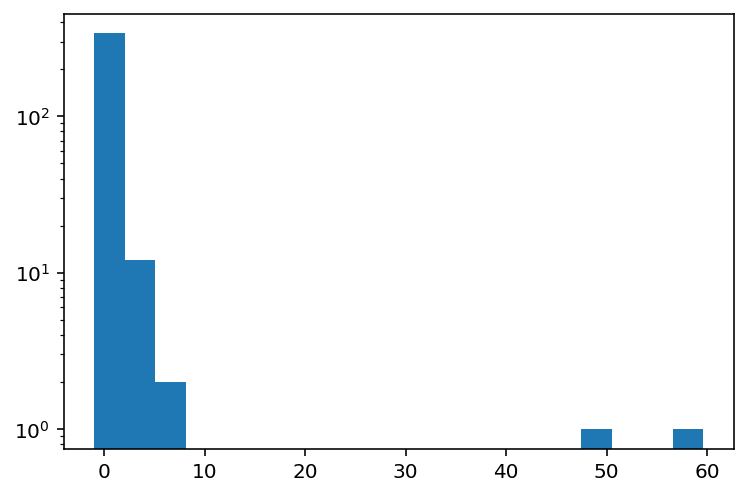

In [60]:
plt.hist(df_pid['Budget_Change_Ratio'], bins=20)
plt.yscale('log')

In [56]:
df_pid[df_pid['Budget_Change_Ratio']>30]

,PID,Project_Name,Category,Borough,Managing_Agency,Client_Agency,Number_Changes,Original_Budget,Design_Start,Original_Schedule,Forecast_Completion,Total_Schedule_Changes,Total_Budget_Changes,Original_Duration,Budget_Change_Ratio,Schedule_Change_Ratio
147,603,"RECONSTRUCTION OF WATER MAIN IN AVENUE S, BK",Water Supply,Brooklyn,DDC,DEP,6,"813,000.00",2016-07-01,2020-09-25,2021-09-21,361.00,"38,838,000.00","1,547.00",47.77,0.23
227,784,Storm Sewer Outlet In 224Th St,Sewers,not_specified,DDC,DEP,5,"1,699,000.00",2017-01-04,2022-11-29,2023-11-29,365.00,"101,247,000.00","2,155.00",59.59,0.17


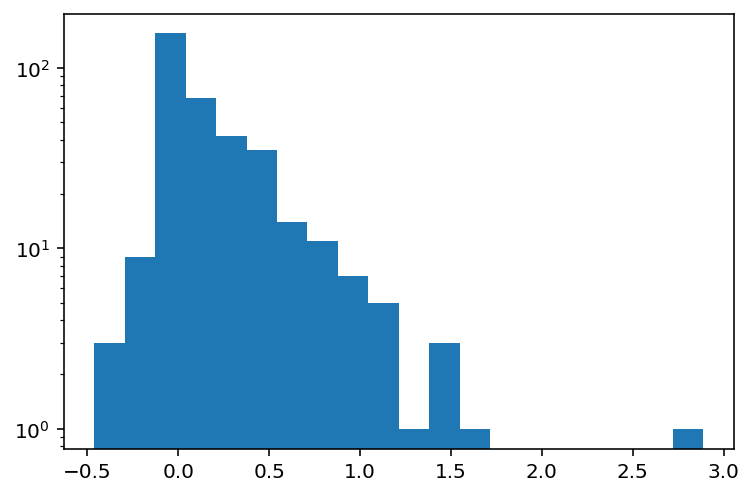

In [54]:
plt.hist(df_pid['Schedule_Change_Ratio'], bins=20)
plt.yscale('log')

In [51]:
df_pid[df_pid['Schedule_Change_Ratio']>1.5]

,PID,Project_Name,Category,Borough,Managing_Agency,Client_Agency,Number_Changes,Original_Budget,Design_Start,Original_Schedule,Forecast_Completion,Total_Schedule_Changes,Total_Budget_Changes,Original_Duration,Budget_Change_Ratio,Schedule_Change_Ratio
33,193,Dumbo and Vinegar Hill Area Roadway Reconstruc...,Streets and Roadways,Brooklyn,DDC,DOT,15,"33,600,000.00",2012-06-07,2015-07-09,2024-06-04,"3,253.00","88,902,000.00","1,127.00",2.65,2.89
45,370,Flatbush Avenue Trunk Watermain Replacement,Wastewater Treatment,Brooklyn,DDC,DEP,12,"19,852,000.00",2014-11-24,2017-07-16,2021-07-12,"1,457.00","31,242,000.00",965.00,1.57,1.51
81,480,BAT Building A - Phase V Activation,Industrial Development,Brooklyn,EDC,not_specified,10,"100,000,000.00",2015-04-10,2017-02-01,2020-02-28,"1,122.00","29,899,998.00",663.00,0.30,1.69


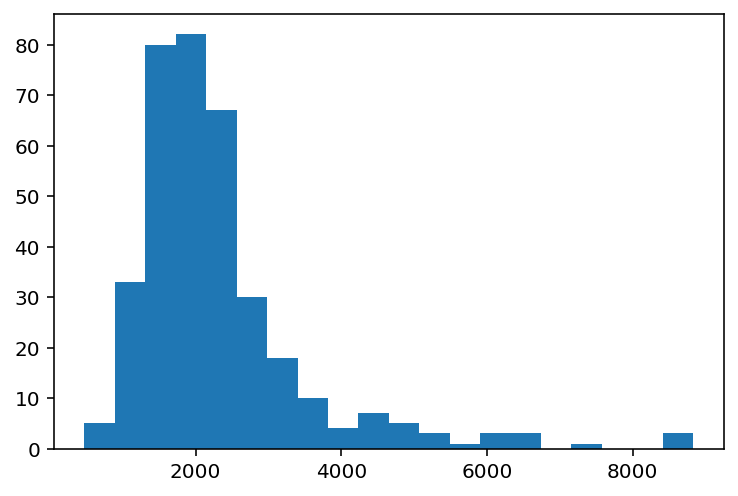

In [53]:
df_pid['Original_Duration'].describe()

plt.hist(df_pid['Original_Duration'], bins=20)
plt.show()

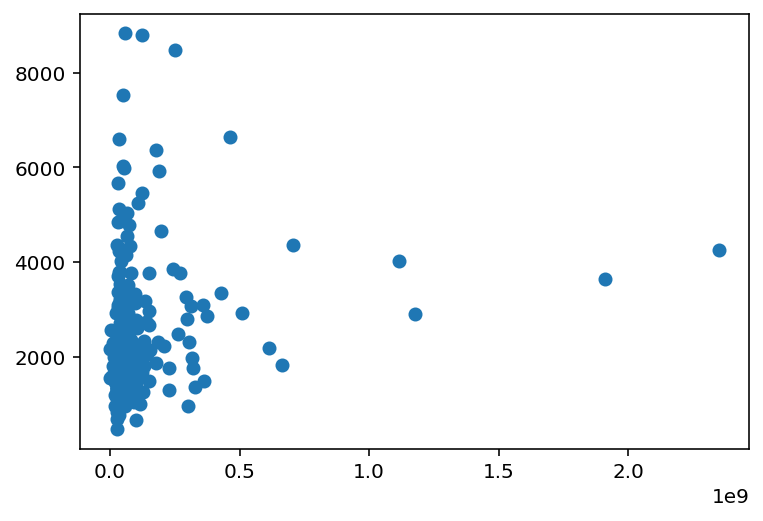

In [45]:
plt.scatter(df_pid['Original_Budget'], df_pid['Original_Duration'])

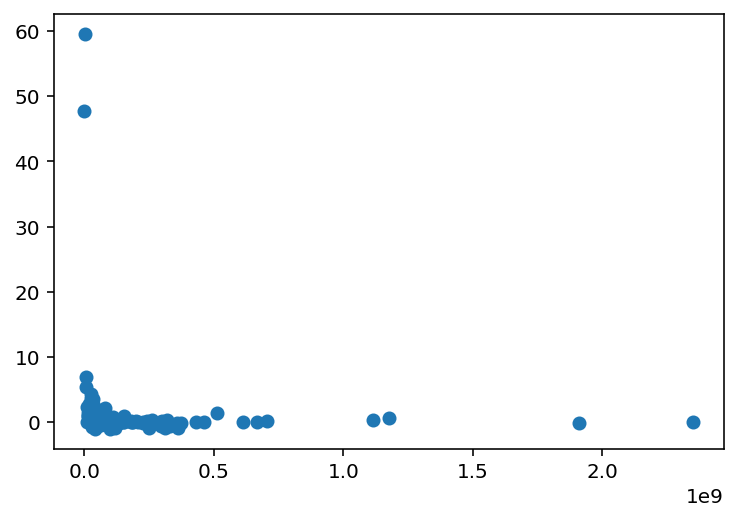

In [79]:
plt.scatter(df_pid['Original_Budget'], df_pid['Budget_Change_Ratio'])

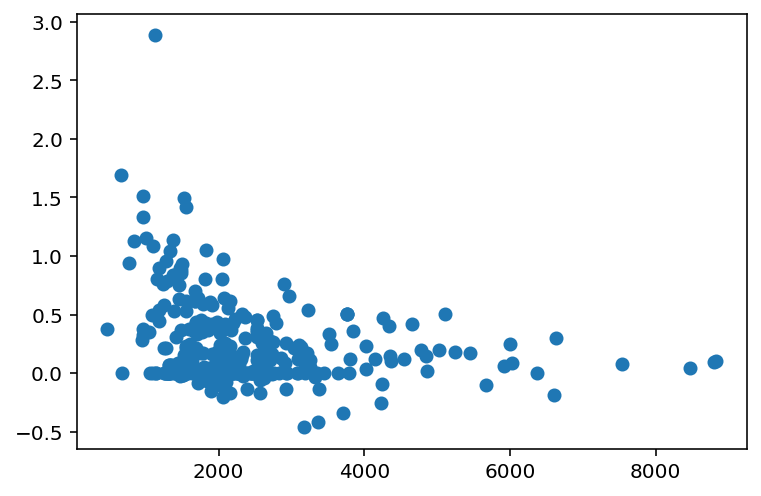

In [80]:
plt.scatter(df_pid['Original_Duration'], df_pid['Schedule_Change_Ratio'])

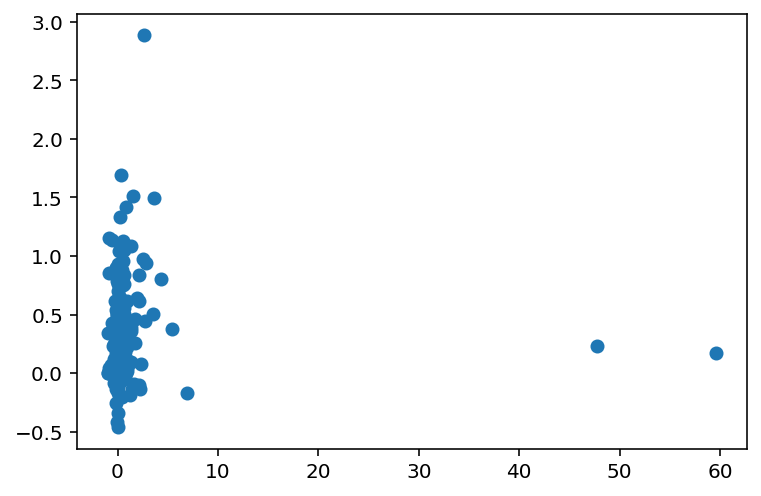

In [81]:
plt.scatter(df_pid['Budget_Change_Ratio'], df_pid['Schedule_Change_Ratio'])

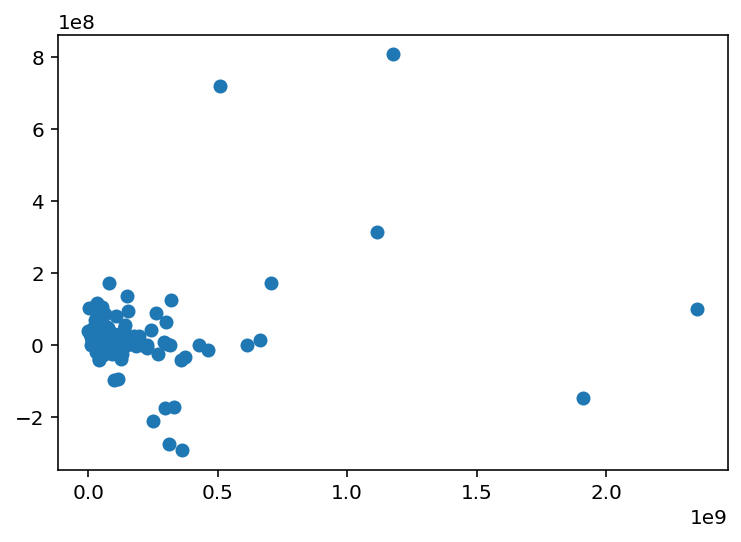

In [46]:
plt.scatter(df_pid['Original_Budget'], df_pid['Total_Budget_Changes'])

In [86]:
list(df_pid)

['PID',
 'Project_Name',
 'Category',
 'Borough',
 'Managing_Agency',
 'Client_Agency',
 'Number_Changes',
 'Original_Budget',
 'Design_Start',
 'Original_Schedule',
 'Forecast_Completion',
 'Total_Schedule_Changes',
 'Total_Budget_Changes',
 'Original_Duration',
 'Budget_Change_Ratio',
 'Schedule_Change_Ratio',
 'Original_Budget_Norm',
 'Original_Duration_Norm',
 'Original_Budget_Std',
 'Original_Duration_Std']

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if sys.path[0] == '':


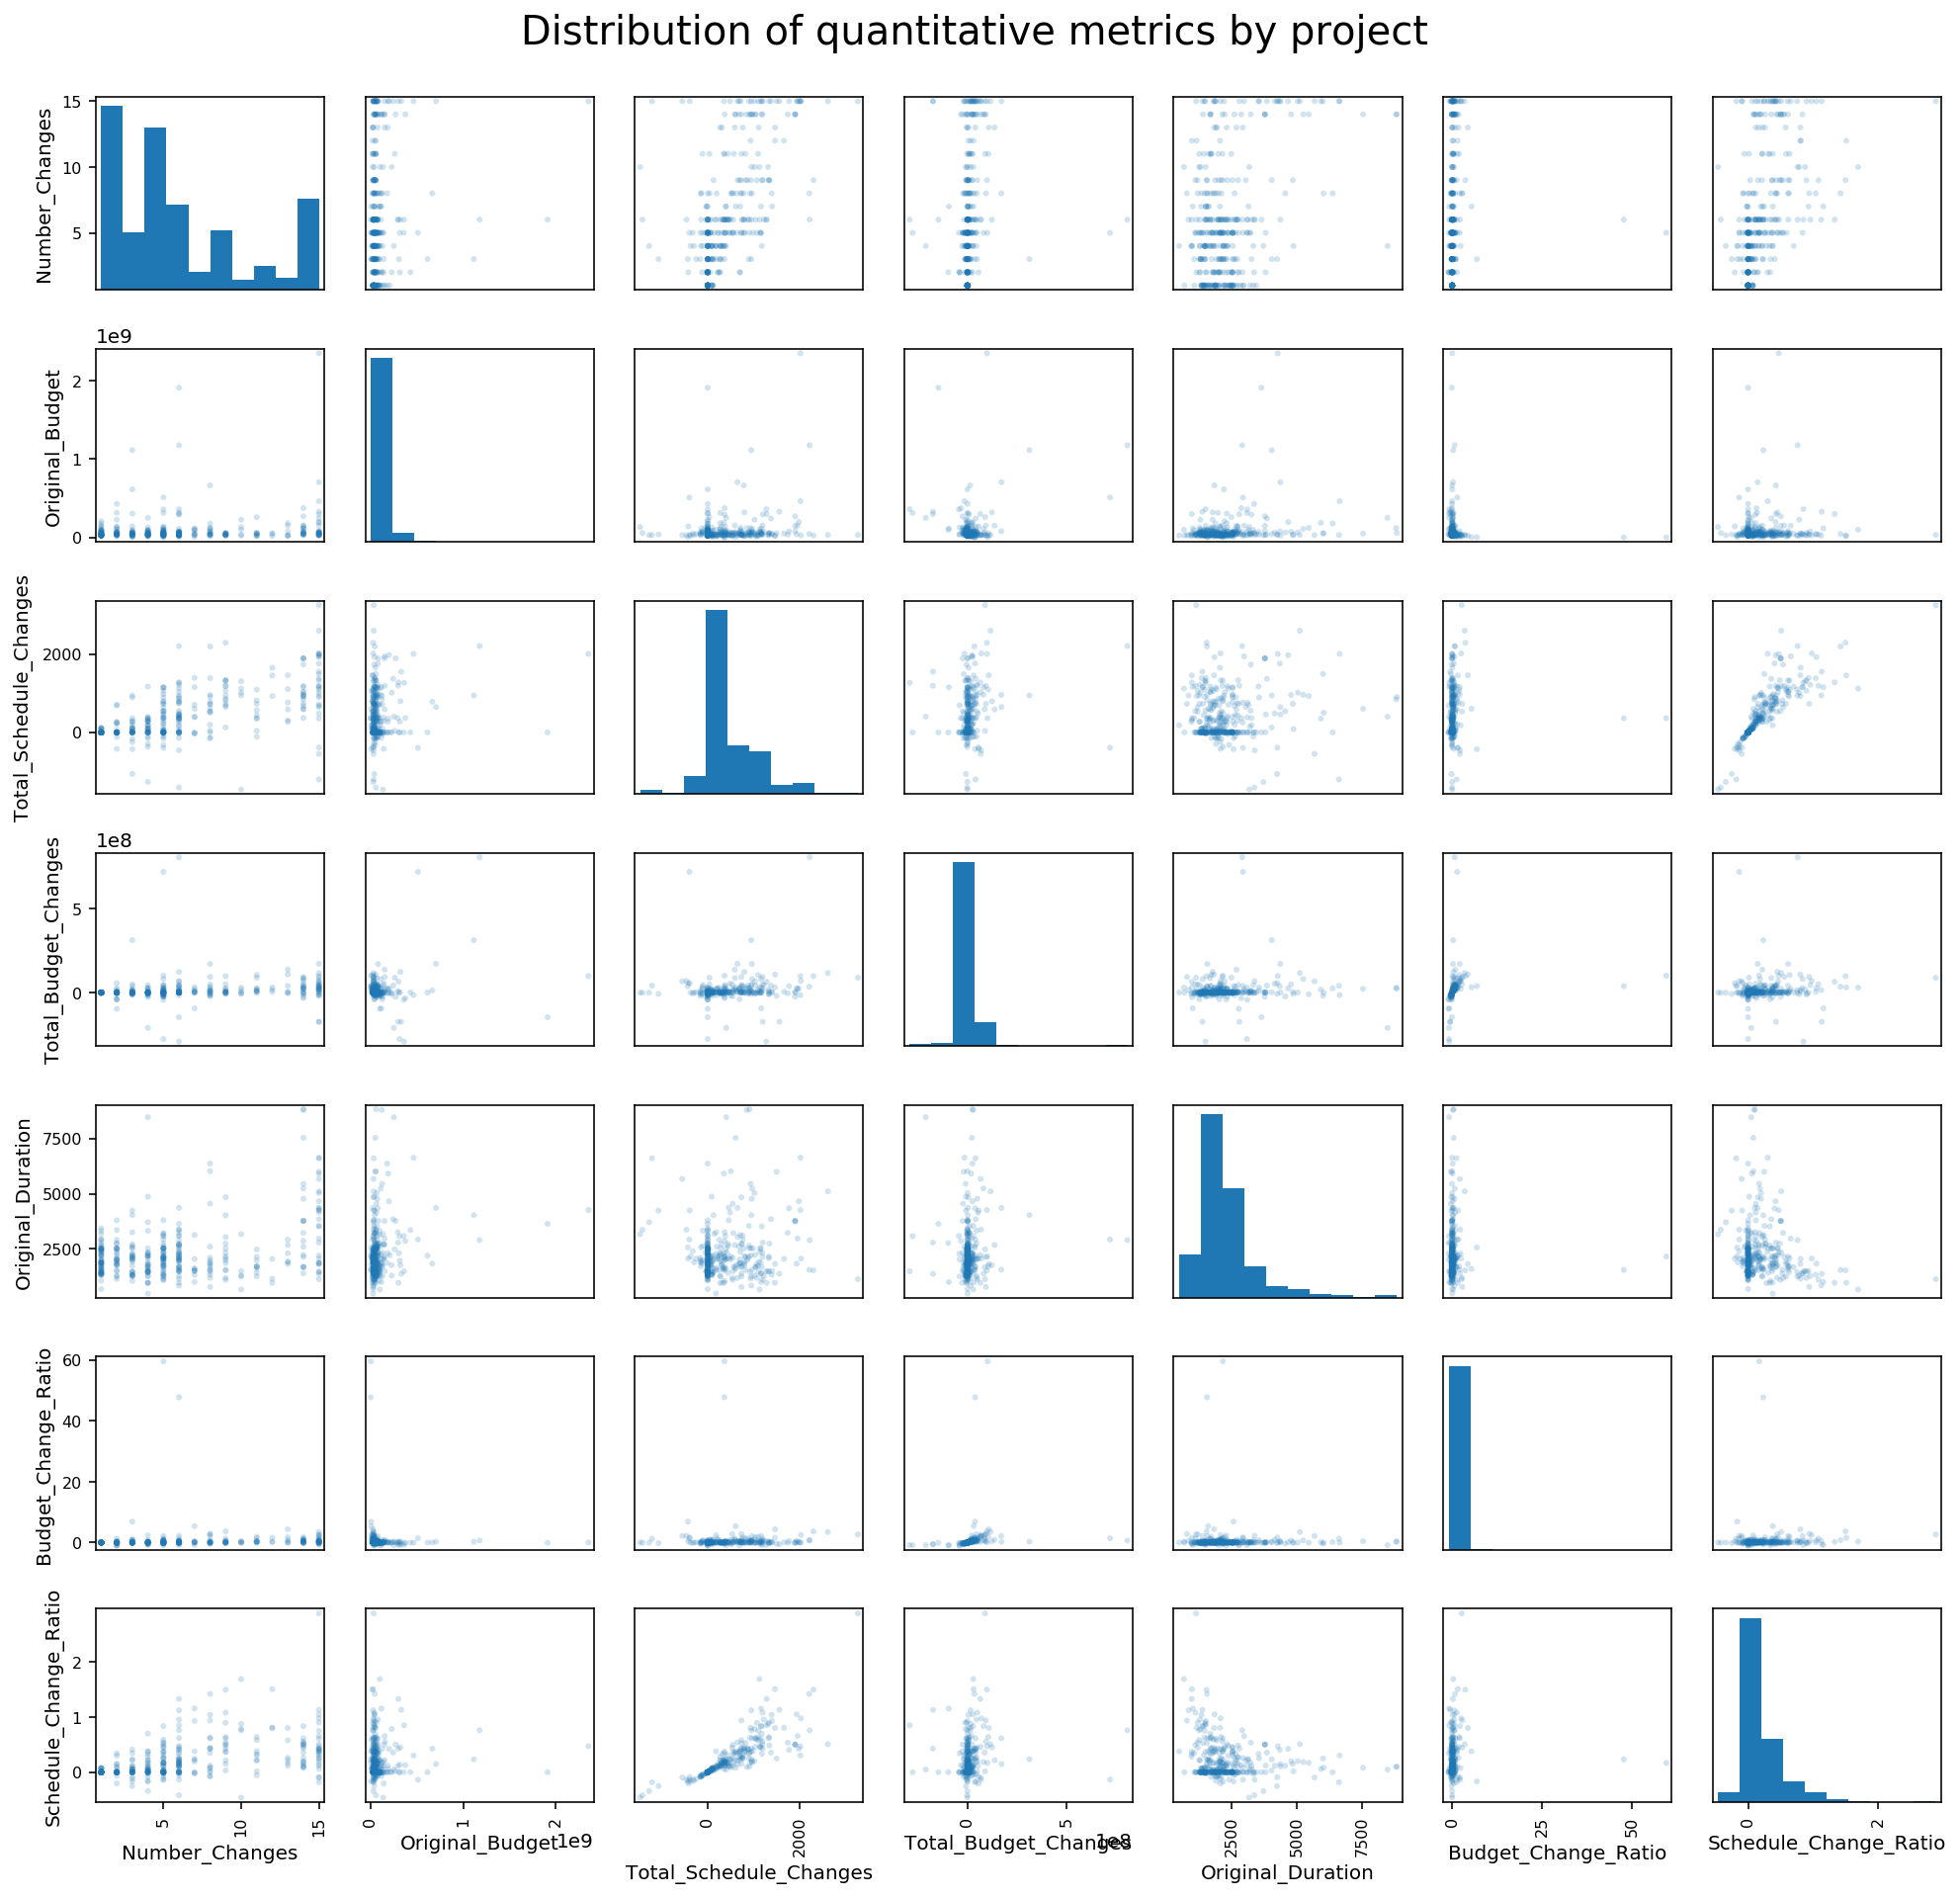

In [103]:
scatter_cols = [
    'Number_Changes',
    'Original_Budget',
    'Total_Schedule_Changes',
    'Total_Budget_Changes',
    'Original_Duration',
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]

fig, ax = plt.subplots(figsize=(14,14))
pd.plotting.scatter_matrix(df_pid[scatter_cols], alpha=0.2, ax=ax)
plt.suptitle('Distribution of quantitative metrics by project', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, .95])
plt.show()

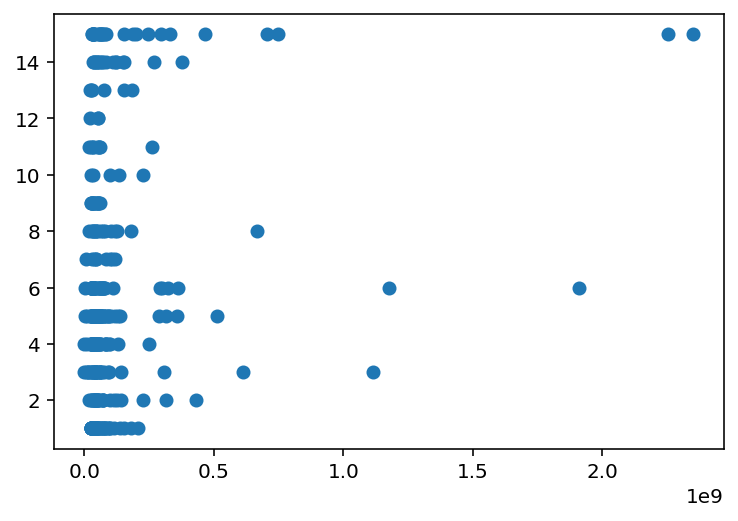

In [113]:
plt.scatter(df_pid['Original_Budget'], df_pid['Number_Changes'])

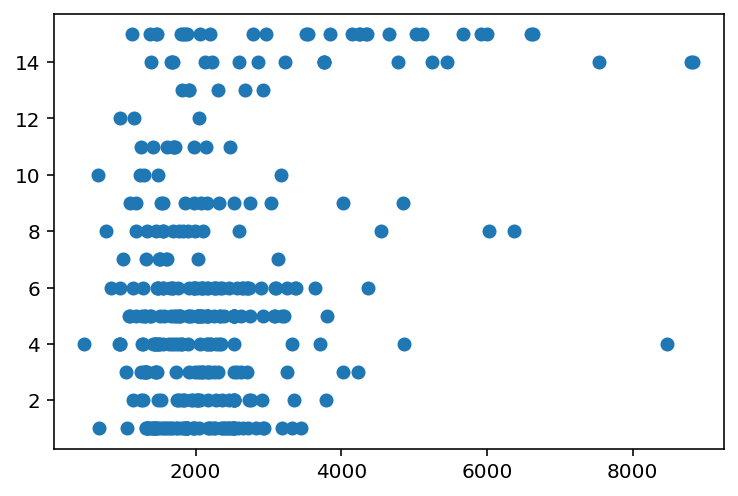

In [114]:
plt.scatter(df_pid['Original_Duration'], df_pid['Number_Changes'])

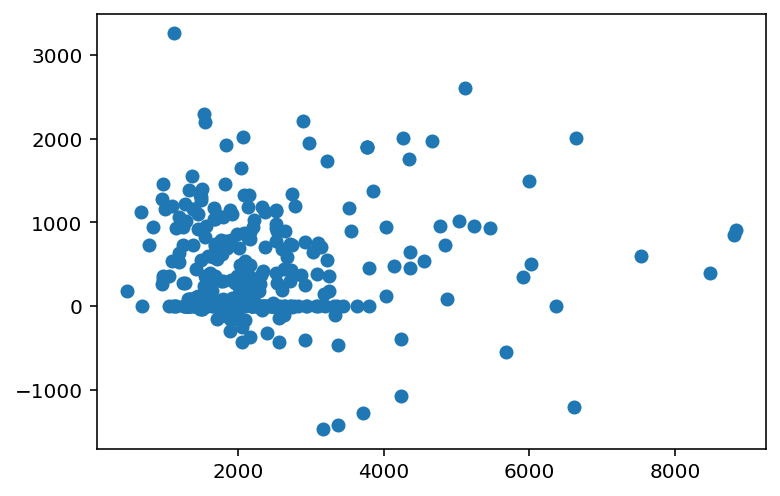

In [115]:
plt.scatter(df_pid['Original_Duration'], df_pid['Total_Schedule_Changes'])

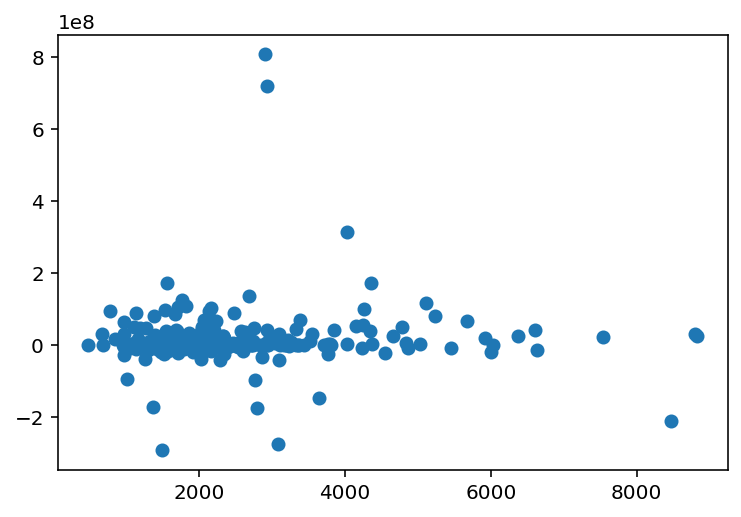

In [116]:
plt.scatter(df_pid['Original_Duration'], df_pid['Total_Budget_Changes'])

In [ ]:


pid = 7

fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,9))

plt.suptitle(
    'PID {}:\n{}\n{}\ninitial duration: {:,.0f} days'.format(
        pid,
        df_pid.loc[pid]['Project Name'][:72],
        df_pid.loc[pid]['Category'],
        df_pid.loc[pid]['Initial Duration']
    ), fontsize=16
)

ax[0].plot(df.loc[df['PID']==pid]['Date Reported As Of'], df.loc[df['PID']==pid]['Budget Forecast'], 'ko-')
ax[0].set_title('Budget forecast by record')
ax[1].plot(df.loc[df['PID']==pid]['Date Reported As Of'], df.loc[df['PID']==pid]['Latest Budget Changes'], 'ko-')
ax[1].axhline(0, color='r', linestyle=':')
ax[1].set_title('Budget change by record')
ax[2].plot(df.loc[df['PID']==pid]['Date Reported As Of'], df.loc[df['PID']==pid]['Latest Schedule Changes'], 'ko-')
ax[2].axhline(0, color='r', linestyle=':')
ax[2].set_title('Schedule change by record')
plt.tight_layout(rect=[0, 0.03, 1, .88])
plt.show()



<a name='budget'></a>
## Budget Values

<a href=#index>index</a>

<a name='missing'></a>
## "Missing-ness"

<a href=#index>index</a>

<a name='summary'></a>
## Summary & Findings

<a href=#index>index</a>

Poor data quality.

Data is inconsistent in quality. Human-entered data will always have inconsistencies. We will need to work around or with that.
Any model will need more data. We will need to source more project data from other regions and types of projects to increase the variety
Lots of missing data.
To feed a model, some data engineering will be necessary. The types of dat that need to be created are not yet understood.
Any efforts to normalize data will need to consider normalization within the project as well as within the entire dataset.

<a name='open'></a>
## Open Items / Unanswered

<a href=#index>index</a>